<a href="https://colab.research.google.com/github/FrederikBornemann/SyReAL/blob/main/PySR_scoring_07_09_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account).
2. (Optional) If you would like to do the deep learning component of this tutorial, turn on the GPU with Edit->Notebook settings->Hardware accelerator->GPU
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 3, 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Delete and disconnect runtime_ and repeat steps 2-4.

**Run the following code to install Julia**

In [2]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.2"
JULIA_PACKAGES="PyCall SymbolicRegression"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done
  
  julia -e 'println("Success")'
fi

Installing Julia 1.7.2 on the current Colab Runtime...
https://storage.googleapis.com/julialang2/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz:
2022-09-09 16:58:44 ERROR 403: Forbidden.
tar: This does not look like a tar archive

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Installing Julia package PyCall...
/bin/bash: line 20: julia: command not found
Installing Julia package SymbolicRegression...
/bin/bash: line 20: julia: command not found
/bin/bash: line 23: julia: command not found


CalledProcessError: ignored

Install PySR and PyTorch-Lightning:

In [ ]:
%pip install -Uq pysr pytorch_lightning

The following step is not normally required, but colab's printing is non-standard and we need to manually set it up PyJulia:


In [ ]:
from julia import Julia

julia = Julia(compiled_modules=False)
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()


Let's install the backend of PySR, and all required libraries. We will also precompile them so they are faster at startup.

**(This may take some time)**

In [ ]:
import pysr

pysr.install()


In [ ]:
from sympy import *
import numpy as np
from matplotlib import pyplot as plt
# import seaborn as sns
#from pysr import PySRRegressor
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
#import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from google.colab import files
import os
import pandas as pd

# sns.set()
# sns.set_theme(style="whitegrid", palette="muted")

# Scoring

In [25]:
np.random.seed(0)
N = 200
upper_sigma = 2
X = 2 * np.random.rand(N, 5)
sigma = np.random.rand(N) * (upper_sigma - 0.1) + 0.1
eps = sigma * np.random.randn(N)
y = 5 * np.cos(3.5 * X[:, 0]) - 1.3 + eps

In [7]:
model = PySRRegressor(
    niterations=20,
    populations=20,
    binary_operators=["plus", "mult"],
    unary_operators=["cos"],
    denoise=True,
    model_selection='best',
)
model.fit(X, y)

/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1206: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
  Activating project at `~/.julia/environments/pysr-0.10.2`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.10.2/Project.toml`
  No Changes to 

Started!

Cycles per second: 2.240e+04
Head worker occupation: 12.9%
Progress: 62 / 400 total iterations (15.500%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           1.219e+01  7.815e-08  -0.7879127
3           1.145e+01  3.116e-02  (x0 + -1.8671883)
4           8.393e+00  3.106e-01  cos(x0 * 3.4636276)
6           1.349e+00  9.142e-01  (cos(x0 * 3.4636276) * 4.6310472)
8           1.401e-02  2.283e+00  ((cos(x0 * 3.518299) * 4.800851) + -1.1722841)
10          1.401e-02  1.788e-07  (((cos(x0 * 3.518299) * 4.843355) + -1.18266) * 0.9912223)
13          1.401e-02  1.633e-04  (((cos(x0 * 3.5184538) * 4.80102) + (cos(x1) * -0.0061642136)) + -1.1693602)
17          1.358e-02  7.764e-03  ((cos(x0 * 3.518299) * 4.800851) + (cos(cos(cos(x0 * 3.518299)) * 0.2878972) * -1.2029574))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 2.760e+04
Head worker occupation: 6.9%
Progress: 153 / 400 total iterations (38.250%

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         -0.7879127   
	1         0.031611                                  (x0 + -1.7656628)   
	2         0.309802                                cos(x0 * 3.4785361)   
	3         0.914121                  (cos(x0 * 3.4636276) * 4.6310472)   
	4         2.283462     ((cos(x0 * 3.518299) * 4.800851) + -1.1722841)   
	5         0.000940  ((cos((x0 * 3.5217524) + -0.0038150367) * 4.80...   
	6         0.012181  (((cos(x0 * 3.5164745) + (x0 * 0.007435686)) *...   
	7   >>>>  0.368083  ((cos(x0 * 3.517321) * (cos(cos(x0 * 3.5180051...   
	8         0.067817  ((cos(x0 * 3.5180016) * ((0.65939134 + cos(cos...   
	9         0.030729  ((cos(x0 * 3.5180016) * ((0.65939134 + cos(cos...   
	10        0.057456  ((cos(x0 * 3.5180016) * (cos(cos(x0 * 3.518001...   
	
	         loss  complexity  
	0   12.186966           1  
	1   11.440326         

In [ ]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()

In [32]:
print(model.equations_.score)

0     0.000000
1     0.031611
2     0.309802
3     0.914121
4     2.283462
5     0.000940
6     0.012181
7     0.368083
8     0.067817
9     0.030729
10    0.057456
Name: score, dtype: float64


In [16]:
output_path='model.csv'
model.equations_.to_csv('model.csv', mode='a', header=not os.path.exists(output_path))

In [17]:
files.download("model.csv") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
print(model.equations_)

    complexity       loss     score  \
0            1  12.186966  0.000000   
1            3  11.440326  0.031611   
2            4   8.392536  0.309802   
3            6   1.348645  0.914121   
4            8   0.014012  2.283462   
5           10   0.013986  0.000940   
6           12   0.013649  0.012181   
7           14   0.006537  0.368083   
8           16   0.005708  0.067817   
9           18   0.005368  0.030729   
10          19   0.005068  0.057456   

                                             equation  \
0                                          -0.7879127   
1                                   (x0 + -1.7656628)   
2                                 cos(x0 * 3.4785361)   
3                   (cos(x0 * 3.4636276) * 4.6310472)   
4      ((cos(x0 * 3.518299) * 4.800851) + -1.1722841)   
5   ((cos((x0 * 3.5217524) + -0.0038150367) * 4.80...   
6   (((cos(x0 * 3.5164745) + (x0 * 0.007435686)) *...   
7   ((cos(x0 * 3.517321) * (cos(cos(x0 * 3.5180051...   
8   ((cos(x0 * 3.5

In [36]:
model.equations_["sample_size"] = pd.Series(N, index=range(model.equations_.score.shape[0]))

In [ ]:
output_path='model.csv'

for N in np.arange(5, 250, 5, dtype=int):
    # calc samples
    np.random.seed(0)
    upper_sigma = 2
    X = 2 * np.random.rand(N, 5)
    sigma = np.random.rand(N) * (upper_sigma - 0.1) + 0.1
    eps = sigma * np.random.randn(N)
    y = 5 * np.cos(3.5 * X[:, 0]) - 1.3 + eps

    # init model
    model = PySRRegressor(
    niterations=20,
    populations=20,
    binary_operators=["plus", "mult"],
    unary_operators=["cos"],
    denoise=True,
    model_selection='best')

    # fit model
    model.fit(X, y)

    # save model to csv
    model.equations_["sample_size"] = pd.Series(N, index=range(model.equations_.score.shape[0]))
    model.equations_.to_csv('model.csv', mode='a', header=not os.path.exists(output_path))

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245])

# Analysis

In [4]:
data = pd.read_csv("models.csv")

In [5]:
print(data)

     Unnamed: 0  complexity      loss     score  \
0             0           1  0.208077  0.000000   
1             1           2  0.143119  0.374228   
2             2           4  0.041711  0.616462   
3             3           6  0.001574  1.638659   
4             4           8  0.000382  0.707753   
..          ...         ...       ...       ...   
481           3           6  1.468552  0.875722   
482           4           8  0.031850  1.915490   
483           5          10  0.030176  0.027003   
484           6          14  0.016633  0.148914   
485           7          16  0.012662  0.136399   

                                              equation  \
0                                          0.095383376   
1                                              cos(x2)   
2                                 cos(x4 * -2.7049935)   
3                   (cos(x4 * 2.7715294) * 0.69023037)   
4             ((cos(x4 * 3.1838963) * x0) * 0.4235415)   
..                                     

In [18]:
s = 5
df1 = data[data['sample_size'] == s]
print (df1.loss.min())

3.901261e-05


In [19]:
N_list = np.arange(5,250,step=5)
scores = []
losses = []
equations = []
for N in N_list:
    df = data[data['sample_size'] == N]
    best_score = df.score.max()
    best_loss = df.loss.min()
    scores.append(best_score)
    losses.append(best_loss)

print(scores)
print(losses)

[1.6386592788795316, 1.5164697876538893, 1.5949016428352754, 0.8422265520414454, 2.602021785284959, 1.95318486195996, 1.171116671739174, 1.86508981536707, 2.0039311973671623, 2.0999543611040075, 1.545690094227106, 2.0087260930139745, 1.955025241107514, 2.8604950729020877, 1.5683244717788365, 1.7364043313452564, 1.864244060941236, 2.0418275403104857, 1.96642341378132, 2.012709162742412, 1.7704453505275728, 2.832887732084196, 2.054712291433792, 2.396775605066109, 2.4508716710078637, 1.854249593993477, 2.424857321579273, 5.827062818987498, 1.8133168557527204, 2.0581253316457158, 2.3681842206844634, 2.337274815091889, 2.019904721938384, 2.1721173144821324, 1.8071762894845675, 1.9305314571130137, 2.123953681040861, 2.432499627515376, 1.884559741972225, 2.283462362064073, 2.430331502172797, 1.862427752665752, 1.738452441488243, 2.4524642879051024, 1.7074193653157332, 1.8172034434955928, 1.9228711982638127, 1.585055698650898, 1.9154903040287097]
[3.901261e-05, 0.0017711776, 0.00017820811, 0.0

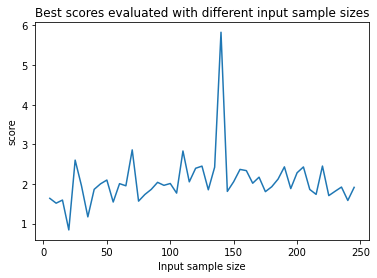

In [34]:
plt.plot(N_list, scores)
plt.xlabel('Input sample size')
plt.ylabel('score')
plt.title('Best scores evaluated with different input sample sizes')
plt.savefig('scores.png', dpi=200)

In [ ]:
scaled_scores = []
for idx, N in enumerate(N_list):
    scaled_score = scores[idx]/(N+100)
    scaled_scores.append(scaled_score)

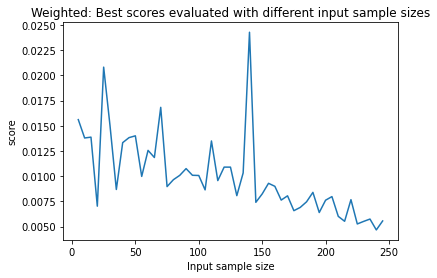

In [35]:
plt.plot(N_list, scaled_scores)
plt.xlabel('Input sample size')
plt.ylabel('score')
plt.title('Weighted: Best scores evaluated with different input sample sizes')
plt.savefig('weighted_scores.png', dpi=200)

In [37]:
files.download("scores.png")
files.download("weighted_scores.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>